In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

In [ ]:
class BurstDetection():
  def __init__(self):
    import pymc as pm
    import arviz as az
    from matplotlib import pyplot as plt
    import numpy as np

  def toy_data_generation(self):
    p = 0.1
    s1 = 2.5
    s2 = 5
    n = 100
    intervals = [(0.3,1),(0.05,s1),(0.4,1),(0.1,s2)]
    pt = []
    for interval, s in intervals:
      pt.extend([s*p]*int(interval*n))

    pt.extend([p]*(n - len(pt)))
    pt = np.array(pt)
    y_true = (pt > p).astype(int)

    np.random.seed(1234)
    Dt = np.random.poisson(1000, n)
    np.random.seed(1234)
    Rt = np.random.binomial(Dt, pt)

    plt.figure(figsize = (8,4))
    plt.title("Toy Data")
    plt.plot(Rt, lw = 2, ls = "--", marker = "+", color="royalblue",alpha = 0.75, label ="Target Events")
    plt.plot(0,Dt[0], lw = 2, ls = "--", marker = "+", color="grey",alpha = 0.5, label ="Base Events")
    plt.legend()
    plt.yticks(color="royalblue")
    plt.twinx()
    plt.plot(Dt, lw = 2, ls = "--", marker = "+", color="grey",alpha = 0.5, label ="Base Events")
    plt.yticks(color="grey")
    plt.show()
    plt.close()
    return Rt, Dt, y_true

  def detection_visualization(self, idata = None, y_true = None, threshold = 0.9):
    from sklearn.metrics import f1_score

    if idata is None: idata = self.idata
    pps = idata.posterior[f"{self.Model.name}::indicators"].to_numpy().reshape((-1,self.n))
    y_hat = (pps.mean(axis=0) > 0.5).astype(int)

    if not y_true is None: print(f"F-score = {f1_score(y_true, y_hat):.4f}")

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.title("Observation")
    plt.plot(self.Rt, lw = 2, ls = "--", marker = "+", color="royalblue",alpha = 0.75, label ="Target Events")
    plt.subplot(2,1,2)
    plt.title("Detected Burst")
    for i in pps:
      pesudo = np.zeros(self.n)
      pesudo[i==1] = np.random.normal(loc=0,scale = 10, size = np.sum(i==1))
      plt.plot(np.arange(self.n), pesudo ,lw = 1, ls ="-", color = "brown", alpha = 0.01)

    bursts = np.arange(pps.shape[1])[(pps.mean(axis=0) > threshold)]
    lb, ub = plt.ylim()
    plt.scatter(bursts, [ub]*len(bursts), marker = "^", color ="red", s=20, label = "Burst wave")
    plt.legend()
    plt.show()
    plt.close()

    return pps

  def customized_lld(self, Rt_,tau, obs):
    return pm.logp(Rt_,obs).sum() - tau.sum()

  def reverse_sigmoid(self, x):
    return np.log(x / (1 - x))

  def original_model(self):
    print("Constructing Original Kleinberg's Burst Detection Model")
    p0 = self.Rt.sum()/self.Dt.sum()
    p1 = p0*self.s
    with pm.Model("Original Kleinberg's Burst Detection Model") as OriginalModel:
      indicators = pm.DiscreteUniform("indicators", 0,1, shape = self.n)
      prob = pm.math.where(indicators >0, p1, p0)
      Rt_ = pm.Binomial("Rt", self.Dt, prob)

      diff = indicators[:-1] - indicators[1:]
      diff = pm.math.where(diff > 0, diff, 0)
      tau = np.log(self.n) * self.gamma * diff
      lld = pm.Potential("lld", self.customized_lld(Rt_,tau, self.Rt))

    self.Model = OriginalModel
    print("Model construction finished")

  def binominal_free_model(self):
    print("Constructing Hyperparameter-Free Binomial Model")
    with pm.Model("Hyperparameter-Free Binomial Model") as BinomialFreeModel:
      mu0 = pm.Normal("mu0",0, 10, initval = self.reverse_sigmoid((self.Rt/self.Dt).mean()))
      mu1 = pm.Normal("mu1", 0, 10, initval= self.reverse_sigmoid((self.Rt/self.Dt).max()))

      p0 = pm.math.invlogit(mu0)
      p1 = pm.math.invlogit(mu1)

      indicators = pm.DiscreteUniform("indicators", 0,1, shape = self.n)
      prob = pm.math.where(indicators >0, p1, p0)

      Rt_ = pm.Binomial("Rt", self.Dt, prob)
      diff = indicators[:-1] - indicators[1:]
      diff = pm.math.where(diff > 0, diff, 0)
      tau = np.log(self.n) * (mu1-mu0)

      lld = pm.Potential("lld", self.customized_lld(Rt_,tau, self.Rt))

    self.Model = BinomialFreeModel
    print("Model construction finished")

  def poisson_model(self):
    print("Constructing Poisson Model")
    lambda0 = np.mean(self.Rt)
    lambda1 = lambda0*self.s
    with pm.Model() as poisson_model:
      indicators = pm.DiscreteUniform("indicators", 0,1, shape = self.n)
      lambda_ = pm.math.where(indicators >0, lambda1, lambda0)

      Rt_ = pm.Poisson("Rt", lambda_)
      diff = indicators[:-1] - indicators[1:]
      diff = pm.math.where(diff > 0, diff, 0)
      tau = np.log(self.n) * self.gamma * diff

      lld = pm.Potential("lld", self.customized_lld(Rt_,tau, self.Rt))

    self.Model = poisson_model
    print("Model construction finished")

  def poisson_free_model(self):
    print("Constructing Hyperparameter-Free Poisson Model")
    with pm.Model("Hyperparameter-Free Poisson Model") as poisson_free_model:
      lambda0 = pm.Exponential("lambda0", 1, initval = self.Rt.mean())
      lambda1 = pm.Exponential("lambda1", 1, initval = self.Rt.max())

      indicators = pm.DiscreteUniform("indicators", 0,1, shape = self.n)
      lambda_ = pm.math.where(indicators >0, lambda1, lambda0)

      Rt_ = pm.Poisson("Rt", lambda_)
      diff = indicators[:-1] - indicators[1:]
      diff = pm.math.where(diff > 0, diff, 0)
      tau = np.log(self.n) * pm.math.log(lambda1 - lambda0) * diff

      lld = pm.Potential("lld", self.customized_lld(Rt_,tau, self.Rt))

    self.Model = poisson_free_model
    print("Model construction finished")

  def pps_sampling(self, nsamples = 500, nchains = 3, seed = 1234):
    with self.Model:
      self.idata = pm.sample(draws = nsamples, tune = nsamples, chains = nchains, random_seed=seed, return_inferencedata = True)
    return self.idata

  def auto_model_construction(self, Rt , Dt = None, s = None, gamma = None):
    self.Rt = Rt
    self.n = len(self.Rt)

    self.Dt = Dt
    self.s = s #2
    self.gamma = gamma #1

    if self.Dt is None:
      if self.s is None or self.gamma is None:
        self.poisson_free_model()
      else:
        self.poisson_model()
    else:
      if self.s is None or self.gamma is None:
        self.binominal_free_model()
      else:
        self.original_model()

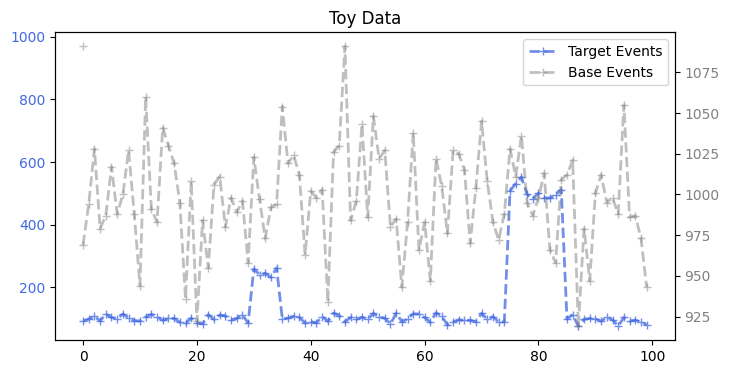

In [ ]:
burst_detection = BurstDetection()
Rt, Dt, y_true = burst_detection.toy_data_generation()

Output()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


F-score = 0.8462


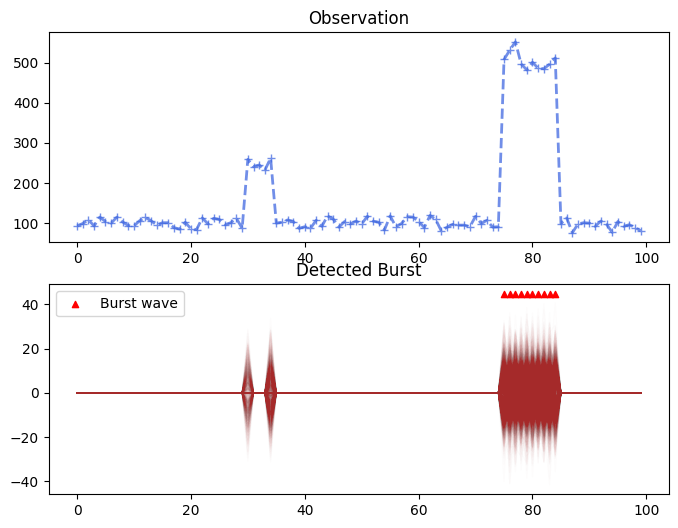

In [ ]:
burst_detection.auto_model_construction(Rt,Dt,s=2,gamma=1)
idata = burst_detection.pps_sampling(nsamples = 1000, nchains = 3, seed = 1234)
pps = burst_detection.detection_visualization(y_true = y_true)

Constructing Hyperparameter-Free Binomial Model
Model construction finished


Output()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


F-score = 0.8000


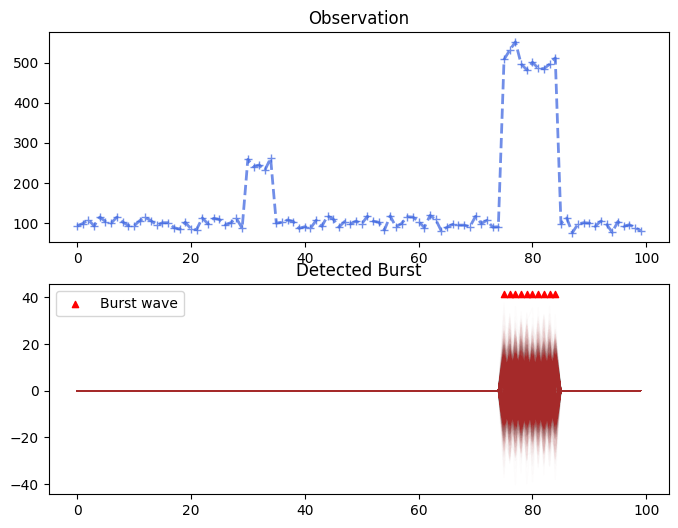

In [ ]:
burst_detection.auto_model_construction(Rt,Dt)
idata = burst_detection.pps_sampling(nsamples = 1000, nchains = 3, seed = 1234)
pps = burst_detection.detection_visualization(y_true = y_true)